In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

## Load Data

In [2]:
import cifar10

Set the path for storing the data-set on your computer.

The CIFAR-10 data-set is about 163 MB and will be downloaded automatically if it is not located in the given path.

In [3]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


Load the class-names.

In [4]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Load the training-set. This returns the images, the class-numbers as integers, and the class-numbers as One-Hot encoded arrays called labels.

In [5]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


Load the test-set.

In [6]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


The CIFAR-10 data-set has now been loaded and consists of 60,000 images and associated labels (i.e. classifications of the images). The data-set is split into 2 mutually exclusive sub-sets, the training-set and the test-set.

In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


The data dimensions are used in several places in the source-code below. They have already been defined in the cifar10 module, so we just need to import them.

In [8]:
from cifar10 import img_size, num_channels, num_classes

The images are 32 x 32 pixels, but we will crop the images to 24 x 24 pixels.

In [9]:
img_size_cropped = 24
train_batch_size = 64

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [10]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

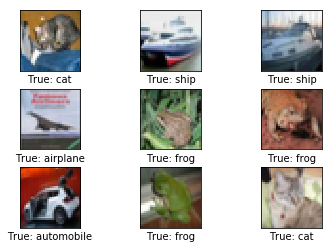

In [11]:
# Get the first images from the test-set.
images = images_test[0:9]

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

The pixelated images above are what the neural network will get as input. The images might be a bit easier for the human eye to recognize if we smoothen the pixels.

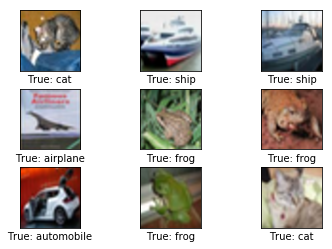

In [12]:
plot_images(images=images, cls_true=cls_true, smooth=True)

In [13]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

In [14]:
y_true_cls = tf.argmax(y_true, dimension=1)

### Data augmentation for images

The following helper-functions create the part of the TensorFlow computational graph that pre-processes the input images. Nothing is actually calculated at this point, the function merely adds nodes to the computational graph for TensorFlow.

The pre-processing is different for training and testing of the neural network:
* For training, the input images are randomly cropped, randomly flipped horizontally, and the hue, contrast and saturation is adjusted with random values. This artificially inflates the size of the training-set by creating random variations of the original input images. Examples of distorted images are shown further below.

* For testing, the input images are cropped around the centre and nothing else is adjusted.

In [15]:
def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.
    
    if training:
        with tf.device('/cpu:0'):
            # For training, add the following to the TensorFlow graph.

            # Randomly crop the input image.
            image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

            # Randomly flip the image horizontally.
            image = tf.image.random_flip_left_right(image)

            # Randomly adjust hue, contrast and saturation.
            image = tf.image.random_hue(image, max_delta=0.05)
            image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
            image = tf.image.random_brightness(image, max_delta=0.2)
            image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

            # Some of these functions may overflow and result in pixel
            # values beyond the [0, 1] range. It is unclear from the
            # documentation of TensorFlow whether this is
            # intended. A simple solution is to limit the range.

            # Limit the image pixels between [0, 1] in case of overflow.
            image = tf.minimum(image, 1.0)
            image = tf.maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

The function above is called for each image in the input batch using the following function.

In [16]:
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    with tf.device('/cpu:0'):
        images = tf.map_fn(lambda image: pre_process_image(image, training), images)

        return images

In order to plot the distorted images, we create the pre-processing graph for TensorFlow, so we may execute it later.

In [17]:
distorted_images = pre_process(images=x, training=True)

### Creating Main Processing

In [18]:
def bias_variable(shape, name):
    initial = tf.constant(0.05, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W, name=None):
    bias = bias_variable([W.shape[-1]], name=('' if name is None else name) + '_bias')
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(x, W, strides=[1, 1, 1, 1],
                                               padding='SAME', name=name), bias), 
                      name=None if name is None else '{}_relu'.format(name))

def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def max_pool_2x2(x, name=None):
    return tf.nn.max_pool(x, ksize=[1, 3, 3, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME', name=name)


class AlexNet:
    def __init__(self, img_size, is_training):
        self.is_training = is_training
        
        self.img_size = img_size
        self.num_channels = 3
        self.class_count = 10
        
        self.layer1_channels = 32
        self.layer2_channels = 64
        self.layer3_channels = 64
        self.layer4_channels = 64
        self.layer5_channels = 32
        
        self.dense_layer_sz = 2048
    
    def _create_layer1(self):
        weight_shape = (5, 5, self.num_channels, self.layer1_channels)
        with tf.name_scope("layer1"):
            w_top = weight_variable(weight_shape, name='w_top')
            w_bottom = weight_variable(weight_shape, name='w_bottom')
            self.layer1_top = tf.nn.lrn(conv2d(x, w_top, name='top')) #max_pool_2x2(
                #, 
                #'top_pooled'
            #)
            self.layer1_bottom = tf.nn.lrn(conv2d(x, w_bottom, name='bottom')) #max_pool_2x2(
                #, 
                #'bottom_pooled'
            #)
            
    def _create_layer2(self):
        weight_shape = (5, 5, self.layer1_channels, self.layer2_channels)
        with tf.name_scope("layer2"):
            w_top = weight_variable(weight_shape, name='w_top')
            w_bottom = weight_variable(weight_shape, name='w_bottom')
            self.layer2_top = max_pool_2x2(
                tf.nn.lrn(conv2d(self.layer1_top, w_top, name='top')), 
                'top_pooled'
            )
            self.layer2_bottom = max_pool_2x2(
                tf.nn.lrn(conv2d(self.layer1_bottom, w_bottom, name='bottom')),
                'bottom_pooled'
            )
            
    def _create_layer3(self): 
        weight_shape = (3, 3, self.layer2_channels, self.layer3_channels)
        with tf.name_scope("layer3"):
            w_top_top = weight_variable(weight_shape, name='w_top_top')
            w_top_bottom = weight_variable(weight_shape, name='w_top_bottom')
            w_bottom_top = weight_variable(weight_shape, name='w_bottom_top')
            w_bottom_bottom = weight_variable(weight_shape, name='w_bottom_bottom')
            
            self.layer3_top = tf.add(conv2d(self.layer2_top, w_top_top, name='top_top'),
                                     conv2d(self.layer2_bottom, w_bottom_top, 'bottom_top'), 
                                     name='top')
            
            self.layer3_bottom = tf.add(conv2d(self.layer2_top, w_top_bottom, name='top_bottom'),
                                        conv2d(self.layer2_bottom, w_bottom_bottom, name='bottom_bottom'),
                                        name='bottom')
            
            
    def _create_layer4(self):
        weight_shape = (3, 3, self.layer3_channels, self.layer4_channels)
        with tf.name_scope("layer4"):
            w_top = weight_variable(weight_shape, name='w_top')
            w_bottom = weight_variable(weight_shape, name='w_bottom')
            
            self.layer4_top = conv2d(self.layer3_top, w_top, name='top')
            self.layer4_bottom = conv2d(self.layer3_bottom, w_bottom, name='bottom')
            
            
    def _create_layer5(self):
        weight_shape = (3, 3, self.layer4_channels, self.layer5_channels)
        with tf.name_scope("layer5"):
            w_top = weight_variable(weight_shape, name='w_top')
            w_bottom = weight_variable(weight_shape, name='w_bottom')
            
            self.layer5_top = max_pool_2x2(conv2d(self.layer4_top, w_top, name='top'), 'top_pooled')
            self.layer5_bottom = max_pool_2x2(conv2d(self.layer4_bottom, w_bottom, name='bottom'), 'bottom_pooled')
            
    def _create_layer6(self):
        with tf.name_scope("layer6"):
            sz_last_layer = 8 * 8 * self.layer5_channels
            
            top_flattened = tf.reshape(self.layer5_top, shape=(-1, sz_last_layer), name='top_flattened')

            bottom_flattened = tf.reshape(self.layer5_bottom, shape=(-1, sz_last_layer), name='bottom_flattened')
            
            w_top = weight_variable((sz_last_layer, self.dense_layer_sz), name='w_top')
            w_bottom = weight_variable((sz_last_layer, self.dense_layer_sz), name='w_bottom')
        
            bias_top = bias_variable([self.dense_layer_sz], "bias_top")
            self.layer6_top = tf.nn.relu(
                tf.nn.bias_add(tf.matmul(top_flattened + bottom_flattened, w_top, name='top_mm'), 
                               bias_top),
                name='top_relu'
            )
            self.layer6_top = tf.nn.dropout(self.layer6_top, keep_prob)
            
            bias_bottom = bias_variable([self.dense_layer_sz], "bias_bottom")
            self.layer6_bottom = tf.nn.relu(
                tf.nn.bias_add(tf.matmul(top_flattened + bottom_flattened, w_bottom, name='bottom_mm'),
                               bias_bottom),
                name='bot_relu'
            )
            self.layer6_bottom = tf.nn.dropout(self.layer6_bottom, keep_prob)
            
    def _create_layer7(self):
        weight_shape = (self.dense_layer_sz, self.dense_layer_sz)
        with tf.name_scope("layer7"):
            w_top = weight_variable(weight_shape, name='w_top')
            w_bottom = weight_variable(weight_shape, name='w_bottom')
            
            bias_top = bias_variable([self.dense_layer_sz], "bias_top")
            self.layer7_top = tf.nn.relu(
                tf.nn.bias_add(tf.matmul(self.layer6_top + self.layer6_bottom, w_top), 
                               bias_top),
                name='top_relu'
            )
            self.layer7_top = tf.nn.dropout(self.layer7_top, keep_prob)

            bias_bottom = bias_variable([self.dense_layer_sz], "bias_bottom")
            self.layer7_bottom = tf.nn.relu(
                tf.nn.bias_add(tf.matmul(self.layer6_top + self.layer6_bottom, w_bottom), 
                               bias_bottom),
                name='bottom_relu'
            )
            self.layer7_bottom = tf.nn.dropout(self.layer7_bottom, keep_prob)
            
        
    def _create_final_layer(self):
        weight_shape = (self.dense_layer_sz, self.class_count)
        with tf.name_scope("final_layer"):
            w = weight_variable(weight_shape, name='w')
            b = bias_variable([self.class_count], 'bias')
            self.logits = tf.matmul(self.layer7_top + self.layer7_bottom, w, name='logits') + b
            self.y_pred = tf.nn.softmax(self.logits)
    
    def _create_loss(self):
        with tf.name_scope("loss"):
            self.loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=self.logits))

    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar('loss', self.loss)
            self.summary = tf.summary.merge_all()    
    
    def build_graph(self, x):
        self._create_layer1()
        self._create_layer2()
        self._create_layer3()
        self._create_layer4()
        self._create_layer5()
        self._create_layer6()
        self._create_layer7()
        self._create_final_layer()
        
        self._create_loss()
        self._create_summaries()
        
        return self.y_pred, self.loss


### Creating Neural Network

Note that the neural network is enclosed in the variable-scope named 'network'. This is because we are actually creating two neural networks in the TensorFlow graph. By assigning a variable-scope like this, we can re-use the variables for the two neural networks, so the variables that are optimized for the training-network are re-used for the other network that is used for testing.

In [19]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)

# https://stackoverflow.com/questions/37660312/run-tensorflow-on-cpu
config = tf.ConfigProto(
        #device_count = {'GPU': 0},
        gpu_options=gpu_options
    )
session = tf.Session(config=config)

In [20]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    with tf.variable_scope('network', reuse=not training):
        # Just rename the input placeholder variable for convenience.
        images = x

        # Create TensorFlow graph for pre-processing.
        images = pre_process(images=images, training=training)

        # Create TensorFlow graph for the main processing.
        alexnet = AlexNet(img_size_cropped, training)
        y_pred, loss = alexnet.build_graph(images)
        
        feed_dict_train = {x: [[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]]]],
                           y_true: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
                           keep_prob: 0.5}
        session.run(tf.global_variables_initializer())
        print(session.run([tf.shape(alexnet.layer7_top),
                          tf.shape(alexnet.layer5_bottom)], feed_dict=feed_dict_train))

    return y_pred, loss

In [21]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

In [22]:
y_pred, loss = create_network(training=True)


[array([   1, 2048], dtype=int32), array([ 1,  8,  8, 32], dtype=int32)]


In [23]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss, global_step=global_step)

In [24]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [25]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [26]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [27]:
saver = tf.train.Saver()

In [28]:
save_dir = 'checkpoints/'

In [29]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [30]:
save_path = os.path.join(save_dir, 'cifar10_cnn')

In [31]:
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from checkpoints/cifar10_cnn-200
Failed to restore checkpoint. Initializing variables instead.


In [32]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

In [33]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()
    writer = tf.summary.FileWriter('./graphs', session.graph)

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch,
                           keep_prob: 0.5}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        
        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc, batch_loss = session.run([accuracy, loss],
                                    feed_dict={x: x_batch,
                           y_true: y_true_batch,
                           keep_prob: 1.0})

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}, Loss: {2}"
            print(msg.format(i_global, batch_acc, batch_loss))

        # Save a checkpoint to disk every 1000 iterations (and last).
        if (i_global % 10000 == 0) or (i == num_iterations - 1):
            # Save all variables of the TensorFlow graph to a
            # checkpoint. Append the global_step counter
            # to the filename so we save the last several checkpoints.
            saver.save(session,
                       save_path=save_path,
                       global_step=global_step)

            print("Saved checkpoint.")

    # Ending time.
    end_time = time.time()
    writer.close()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [34]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Plot confusion matrix

In [35]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### Calculating classifications

This function calculates the predicted classes of images and also returns a boolean array whether the classification of each image is correct.

The calculation is done in batches because it might use too much RAM otherwise. If your computer crashes then you can try and lower the batch-size.

In [36]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = train_batch_size
print(batch_size)

def predict_cls(images, labels, cls_true):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)
        if j != i + batch_size:
            break

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :],
                    keep_prob: 1.0}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

64


Calculate the predicted class for the test-set.

In [37]:
def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

### Helper-functions for the classification accuracy

This function calculates the classification accuracy given a boolean array whether each image was correctly classified. E.g. `classification_accuracy([True, True, False, False, False]) = 2/5 = 0.4`. The function also returns the number of correct classifications.

In [38]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.
    
    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

### Helper-function for showing the performance

Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

In [39]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Perform optimization

In [40]:
optimize(num_iterations=100)

Global Step:    100, Training Batch Accuracy:  15.6%, Loss: 2.296966552734375
Saved checkpoint.
Time usage: 0:00:19


Accuracy on Test-Set: 11.4% (1142 / 10000)
Example errors:


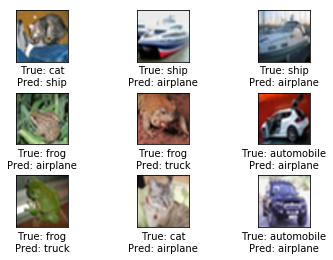

Confusion Matrix:
[822   0   0   0   0   1   0   0  51 126] (0) airplane
[733   0   0   0   0   4   0   7  26 230] (1) automobile
[688   0   0   0   0   4   0   5  14 289] (2) bird
[730   0   0   0   0   4   1   2  20 243] (3) cat
[615   0   0   0   0   1   0   5   7 372] (4) deer
[757   0   0   0   0   3   1   5  18 216] (5) dog
[613   0   0   0   0   4   0   8   5 370] (6) frog
[595   0   0   0   1   5   0   2   7 390] (7) horse
[851   0   0   0   0   0   0   2  74  73] (8) ship
[730   0   0   0   0   4   0   9  16 241] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [41]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

In [42]:
optimize(num_iterations=20000)

Global Step:    200, Training Batch Accuracy:  20.3%, Loss: 2.167578935623169
Global Step:    300, Training Batch Accuracy:  26.6%, Loss: 2.1563711166381836
Global Step:    400, Training Batch Accuracy:  10.9%, Loss: 2.193533182144165
Global Step:    500, Training Batch Accuracy:  12.5%, Loss: 2.179103374481201
Global Step:    600, Training Batch Accuracy:  25.0%, Loss: 2.038137674331665
Global Step:    700, Training Batch Accuracy:  18.8%, Loss: 2.1195340156555176
Global Step:    800, Training Batch Accuracy:  17.2%, Loss: 2.110907793045044
Global Step:    900, Training Batch Accuracy:  21.9%, Loss: 2.0448598861694336
Global Step:   1000, Training Batch Accuracy:  25.0%, Loss: 2.012906074523926
Global Step:   1100, Training Batch Accuracy:  26.6%, Loss: 2.11580228805542
Global Step:   1200, Training Batch Accuracy:  37.5%, Loss: 1.908886432647705
Global Step:   1300, Training Batch Accuracy:  29.7%, Loss: 1.8691481351852417
Global Step:   1400, Training Batch Accuracy:  28.1%, Loss: 1

Global Step:  10600, Training Batch Accuracy:  89.1%, Loss: 0.4486547112464905
Global Step:  10700, Training Batch Accuracy:  78.1%, Loss: 0.637656569480896
Global Step:  10800, Training Batch Accuracy:  75.0%, Loss: 0.7248972654342651
Global Step:  10900, Training Batch Accuracy:  89.1%, Loss: 0.558882474899292
Global Step:  11000, Training Batch Accuracy:  87.5%, Loss: 0.4263879060745239
Global Step:  11100, Training Batch Accuracy:  82.8%, Loss: 0.4942745566368103
Global Step:  11200, Training Batch Accuracy:  87.5%, Loss: 0.6022006869316101
Global Step:  11300, Training Batch Accuracy:  87.5%, Loss: 0.6604571342468262
Global Step:  11400, Training Batch Accuracy:  84.4%, Loss: 0.4504702687263489
Global Step:  11500, Training Batch Accuracy:  85.9%, Loss: 0.42912694811820984
Global Step:  11600, Training Batch Accuracy:  90.6%, Loss: 0.4594970941543579
Global Step:  11700, Training Batch Accuracy:  81.2%, Loss: 0.5787080526351929
Global Step:  11800, Training Batch Accuracy:  75.0%,

## Results

Examples of mis-classifications are plotted below. Some of these are difficult to recognize even for humans and others are reasonable mistakes e.g. between a large car and a truck, or between a cat and a dog, while other mistakes seem a bit strange.

Accuracy on Test-Set: 71.3% (7131 / 10000)
Example errors:


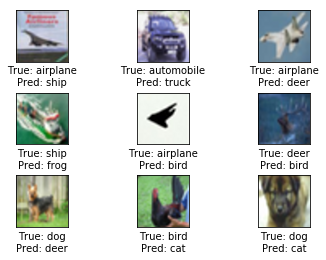

Confusion Matrix:
[747  15  40  22  24  14  11  12  76  39] (0) airplane
[ 14 855   3  10   4   8  21   5  28  52] (1) automobile
[ 66   4 523  70 121  64  93  28  22   9] (2) bird
[ 18   4  46 492  96 152 125  26  17  24] (3) cat
[ 13   2  39  52 752  22  64  43  10   3] (4) deer
[ 10   0  34 186  69 594  58  32  11   6] (5) dog
[  5   1  22  48  46  17 847   4   5   5] (6) frog
[ 12   0  25  43  99  51  17 736   6  11] (7) horse
[ 80  34   7  12  11  10  10   3 815  18] (8) ship
[ 22  97   4  26   5  12  12  19  33 770] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [43]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

In [44]:
#optimize(num_iterations=20000)

Global Step:  20200, Training Batch Accuracy:  98.4%, Loss: 0.20848432183265686


KeyboardInterrupt: 

In [ ]:
#print_test_accuracy(show_example_errors=True,
#                    show_confusion_matrix=True)